In this notebook we will estimate the periodicity component with different methods than the one used in AR.ipynb. But this time we will impute the missing data to see if it removes the shift between periodicity and the series.

In [1]:
cd(@__DIR__)
include("table_reader.jl")
include("utils/utils.jl")

MAPE (generic function with 2 methods)

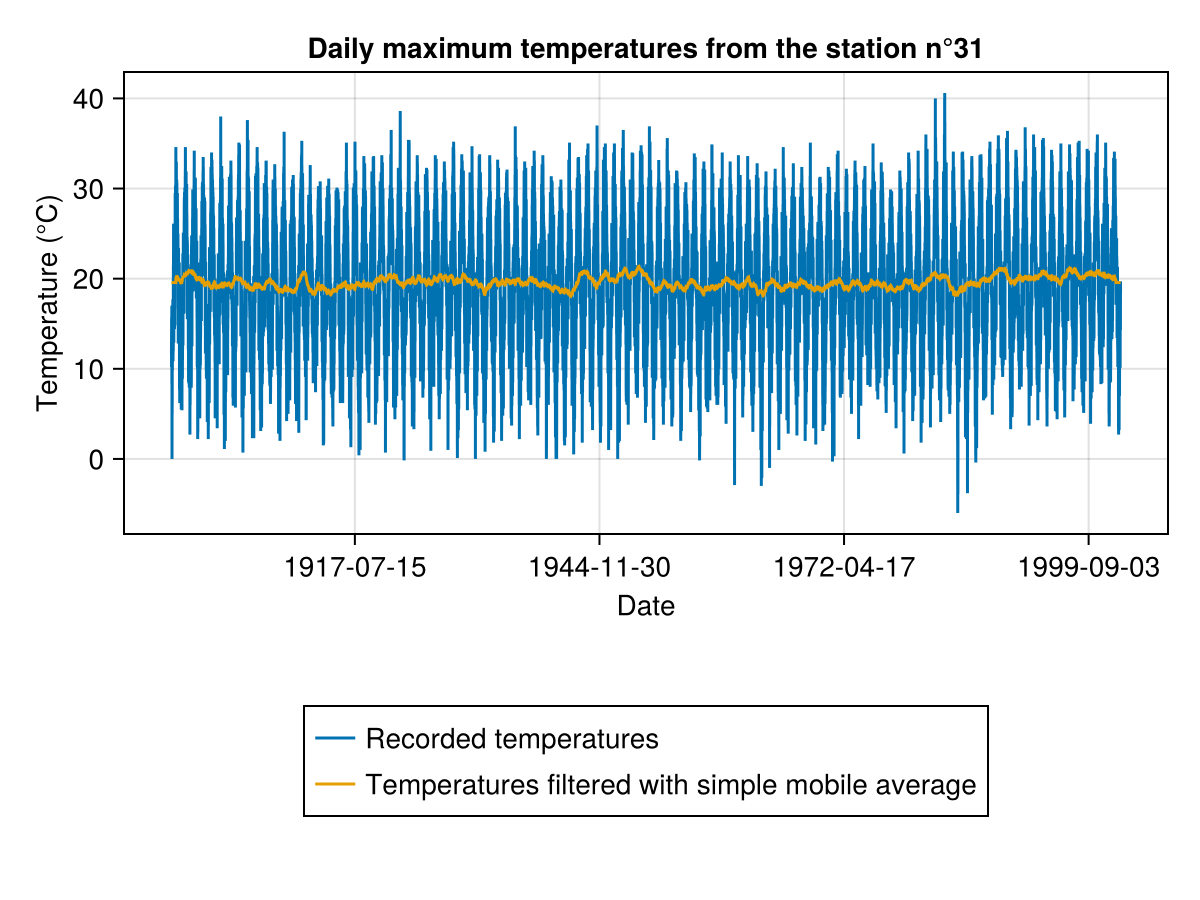

In [2]:
series,fig=extract_series("TX_STAID000031.txt",plot=true)
fig

## Drift

MSE estimators to estimate drift

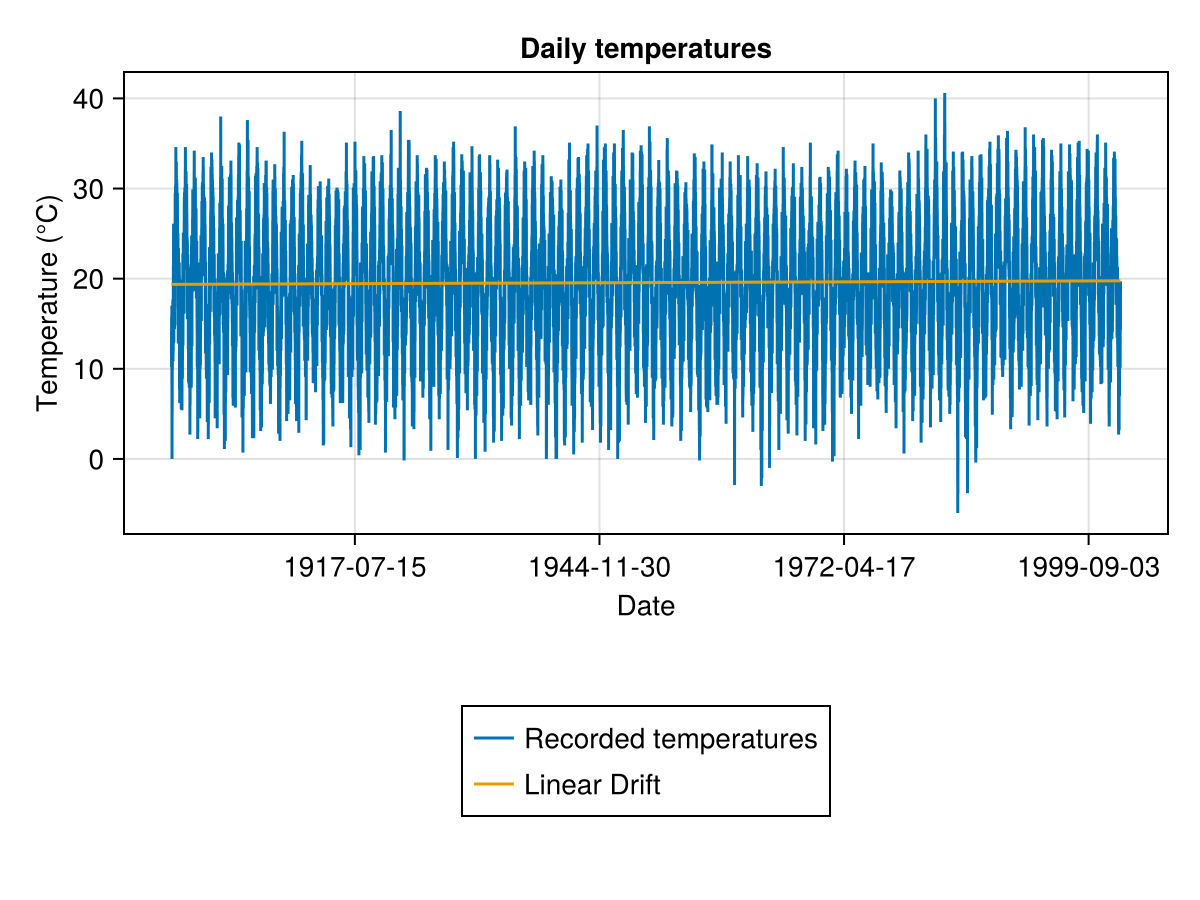

Intercept = 19.366009056392556
Slope = 1.0215034069842917e-5


In [3]:
N=size(series)[1]
X=cat(ones(N),1:N,dims=2)
beta=inv(transpose(X)*X)*transpose(X)*series[!,2]

fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE, series[!,2])
plot2=lines!(ax,series.DATE,X*beta)
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Linear Drift"])
display(fig)

println("Intercept = $(beta[1])")
println("Slope = $(beta[2])")

We can see that the drift is (almost) only a constant. We can consider it in our periodicity component estimation, as the $\mu$ parameter.

In [ ]:
try 
    using RCall
catch ; 
    import Pkg
    Pkg.add("RCall")
    using RCall
end
R"""
z<-$(series[!,2])
t<-1:$N
model<-lm(z~t)
summary(model)
"""

In [4]:
include("utils/Missing_values.jl")
ImputeMissingValues!(series[!,2],series.DATE)
N=length(series[!,2])

47 days imputated into the series


38805

# 1.Trigonometrical parametrical model

In this model the periodicity $S_t$ will follow this equation :  $S_t = \mu + a\cos(\frac{2πt}{365.25}) + b\sin(\frac{2πt}{365.25})$. $\mu$, $a$ and $b$ will be estimated by fitting this equation on our series with an OLS regression.

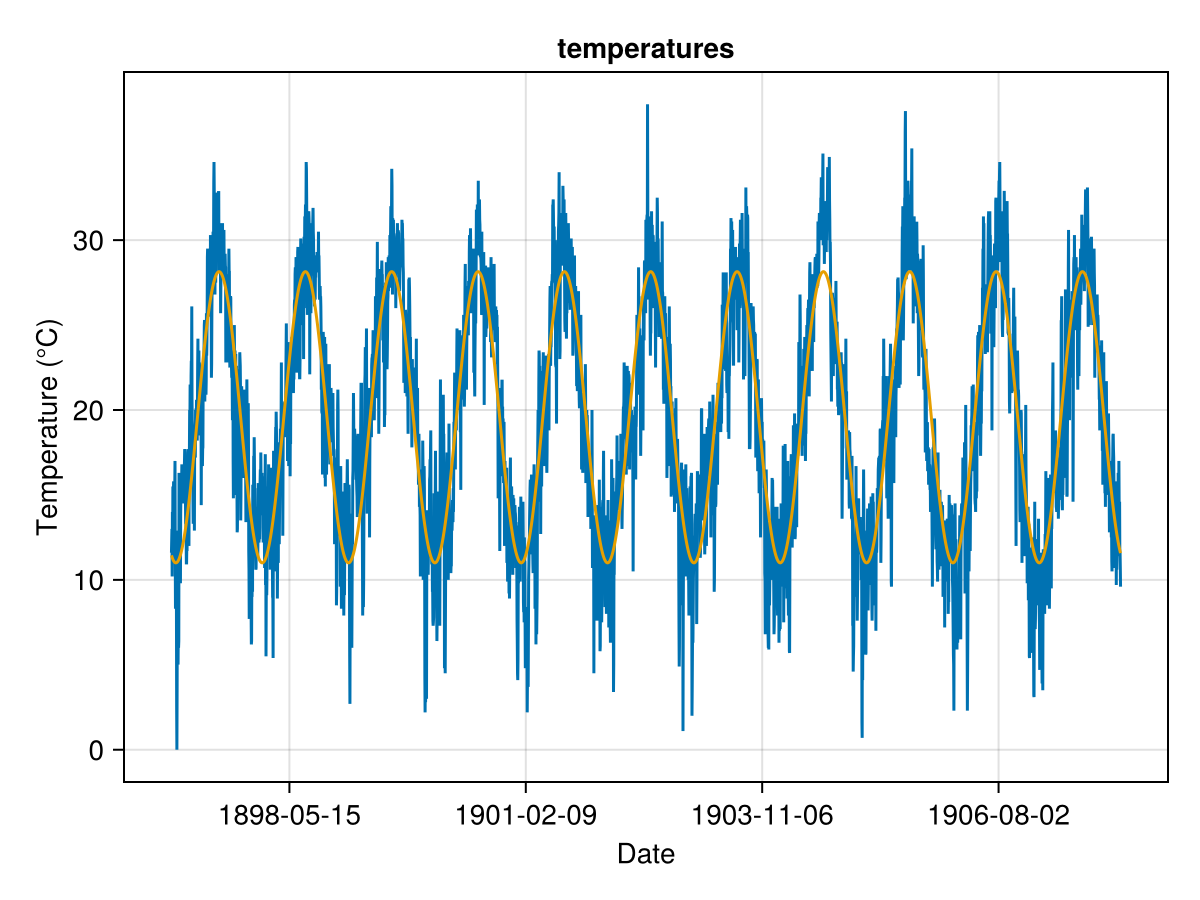

In [5]:
include("utils/periodicity.jl")
trigo_function=fitted_periodicity(series[!,2])
periodicity=trigo_function.(1:N)

Myyear=Iyear(series.DATE,year(series.DATE[1]):year(series.DATE[1]) + 10)
fig, ax = lines(series.DATE[Myyear],series[Myyear,2])
lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

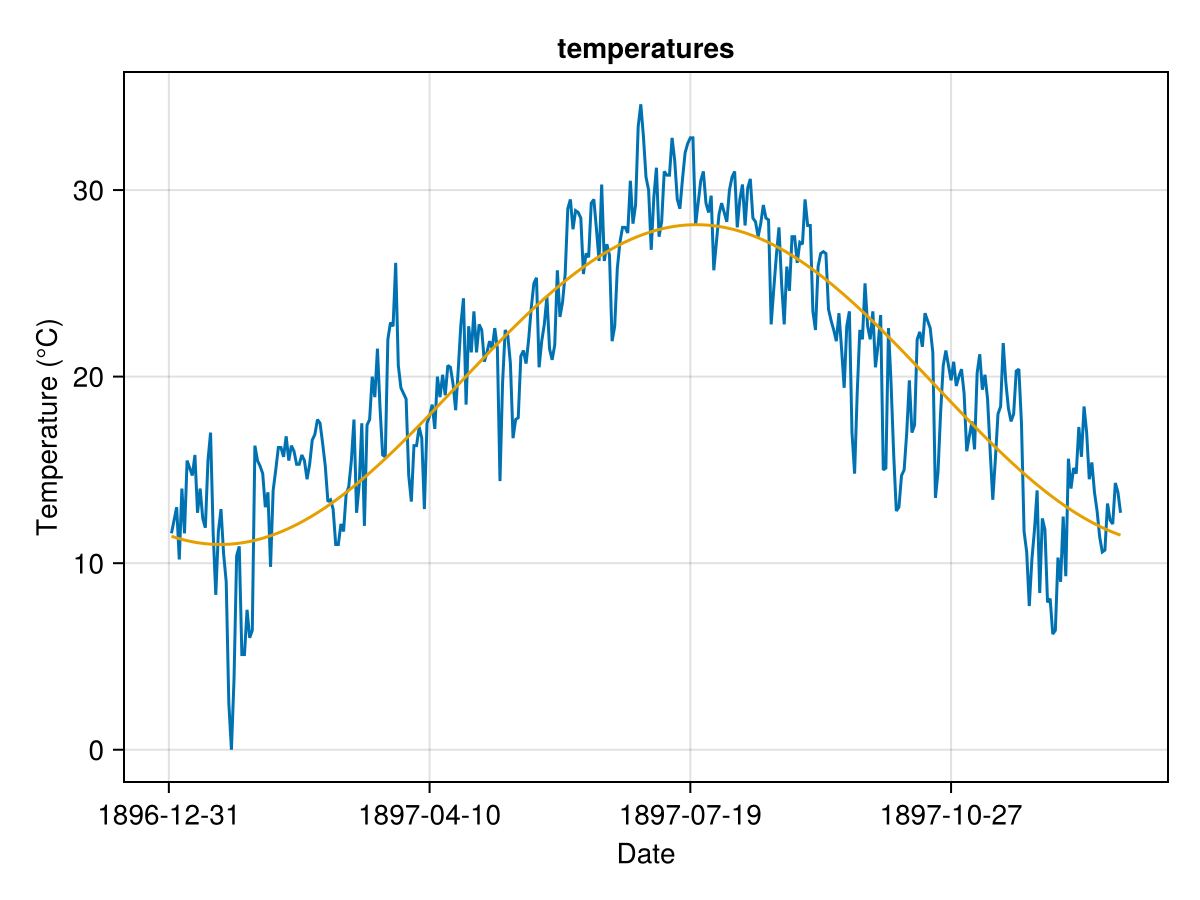

In [6]:
Myyear=Iyear(series.DATE,year(series.DATE[1]))
fig, ax = lines(series.DATE[Myyear],series[Myyear,2])
lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

We will work on the series without the periodicity : 

In [7]:
x=series[!,2]-periodicity

38805-element Vector{Float64}:
  0.1571733303306786
  0.9025807554782155
  1.6455685571830738
 -1.1138759858801954
  2.7242351247636574
  0.35989061094215913
  4.293079921172671
  3.923793233784849
  3.552021459827193
  4.67775624575669
  ⋮
  3.1148196390843523
  0.9855756895720891
 -0.544869543313574
 -1.4764774570800157
  0.3907908948334349
  3.1569747915353403
  3.522113833055723
  1.9862479286246106
  2.5494172848670615

## Autocorrelations

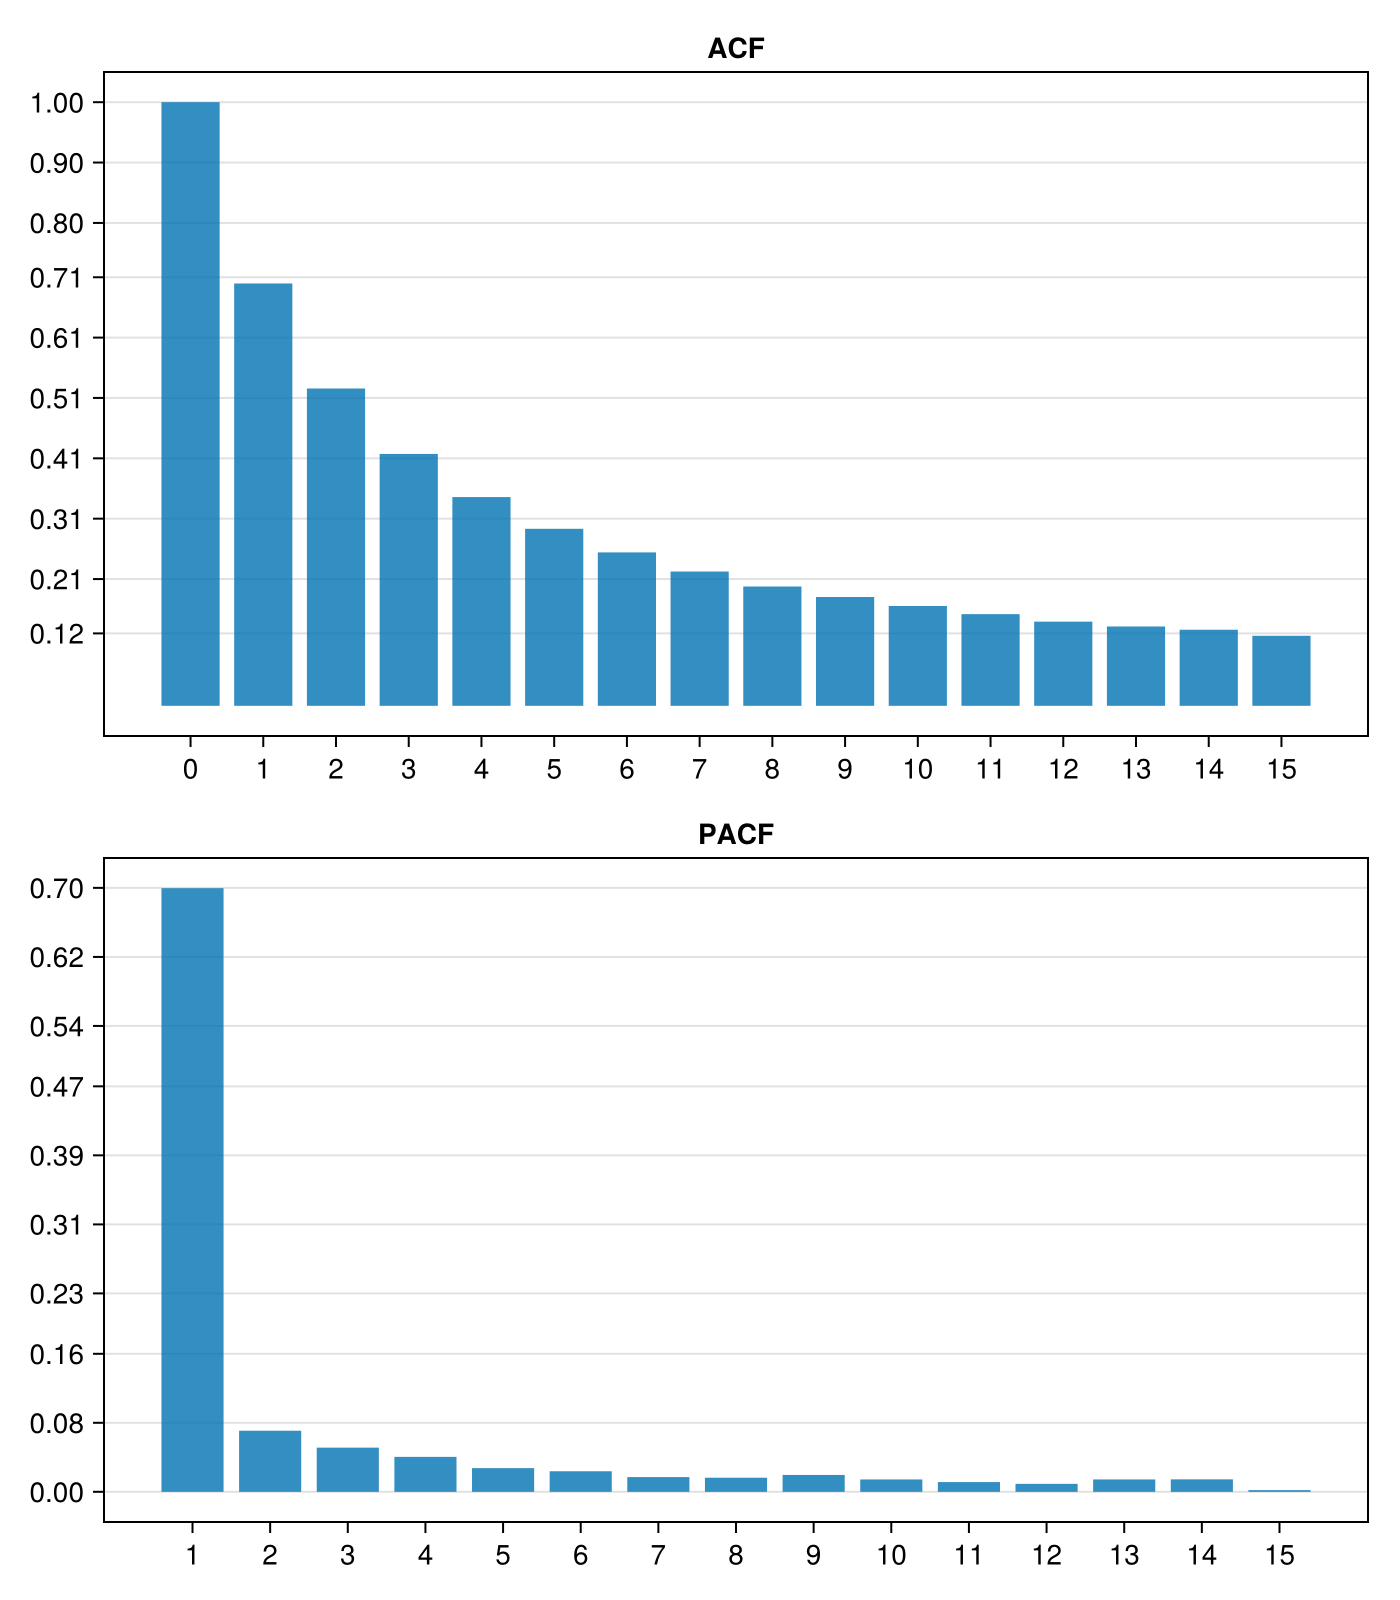

In [8]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

It still looks like an AR(1) model

## Estimation and simulation

In [9]:
include("utils/Estimation.jl")
include("utils/Simulation.jl")
include("utils/Plotting.jl")

PlotParameters

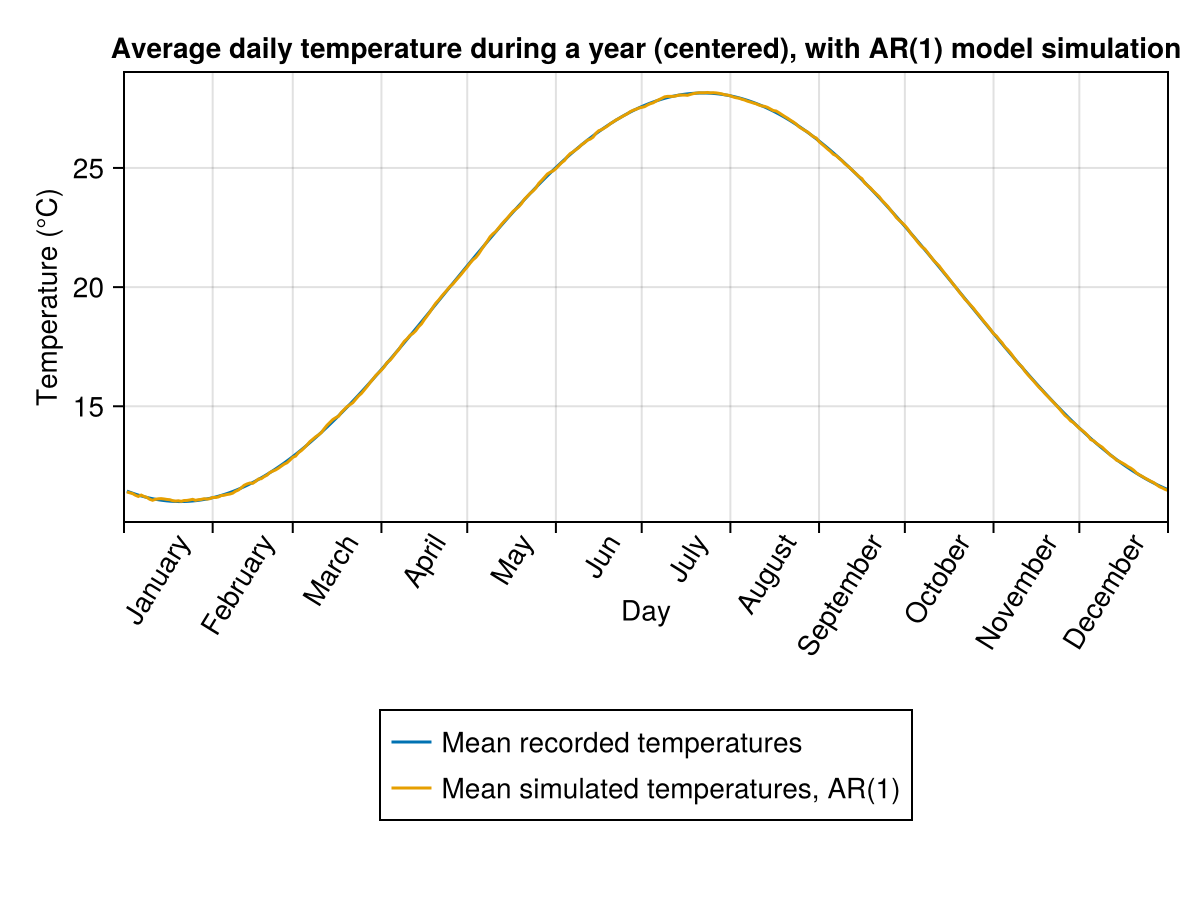

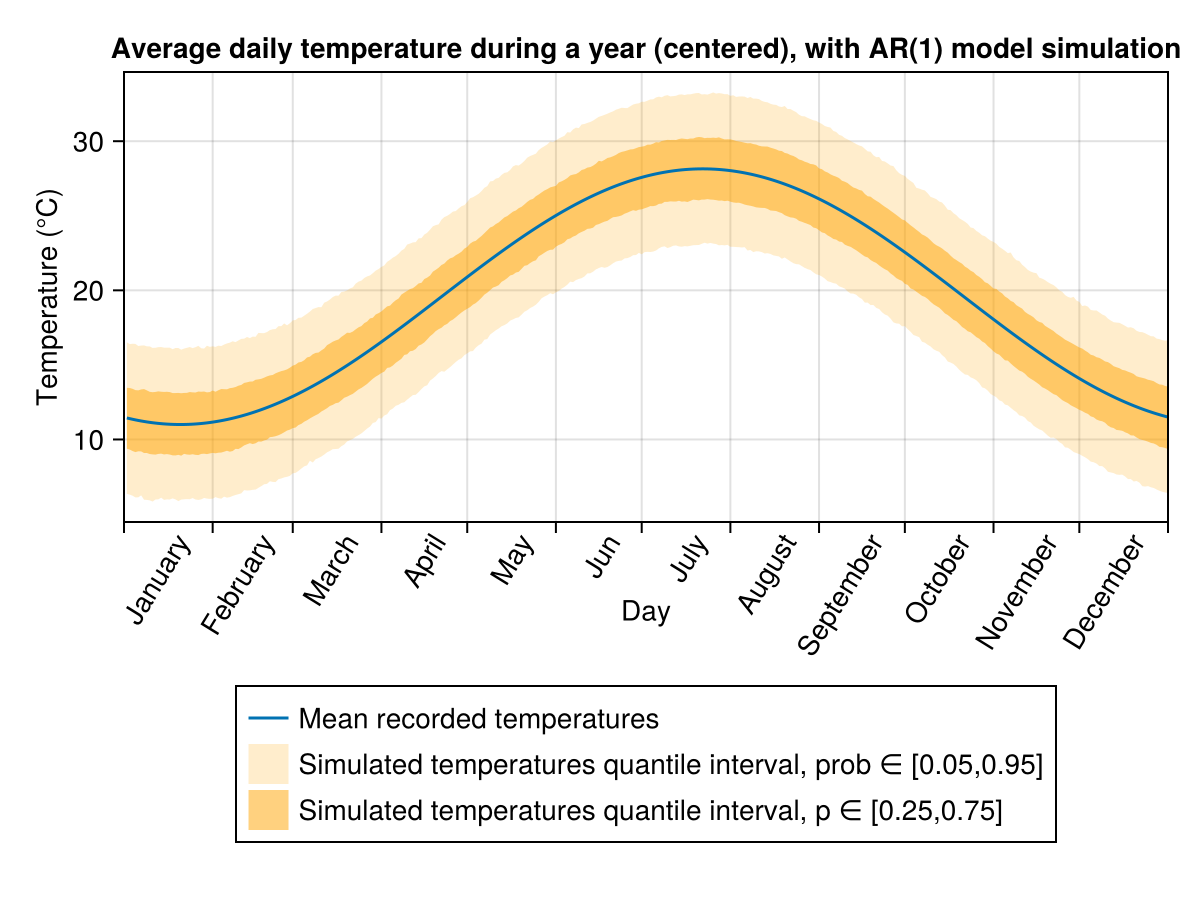

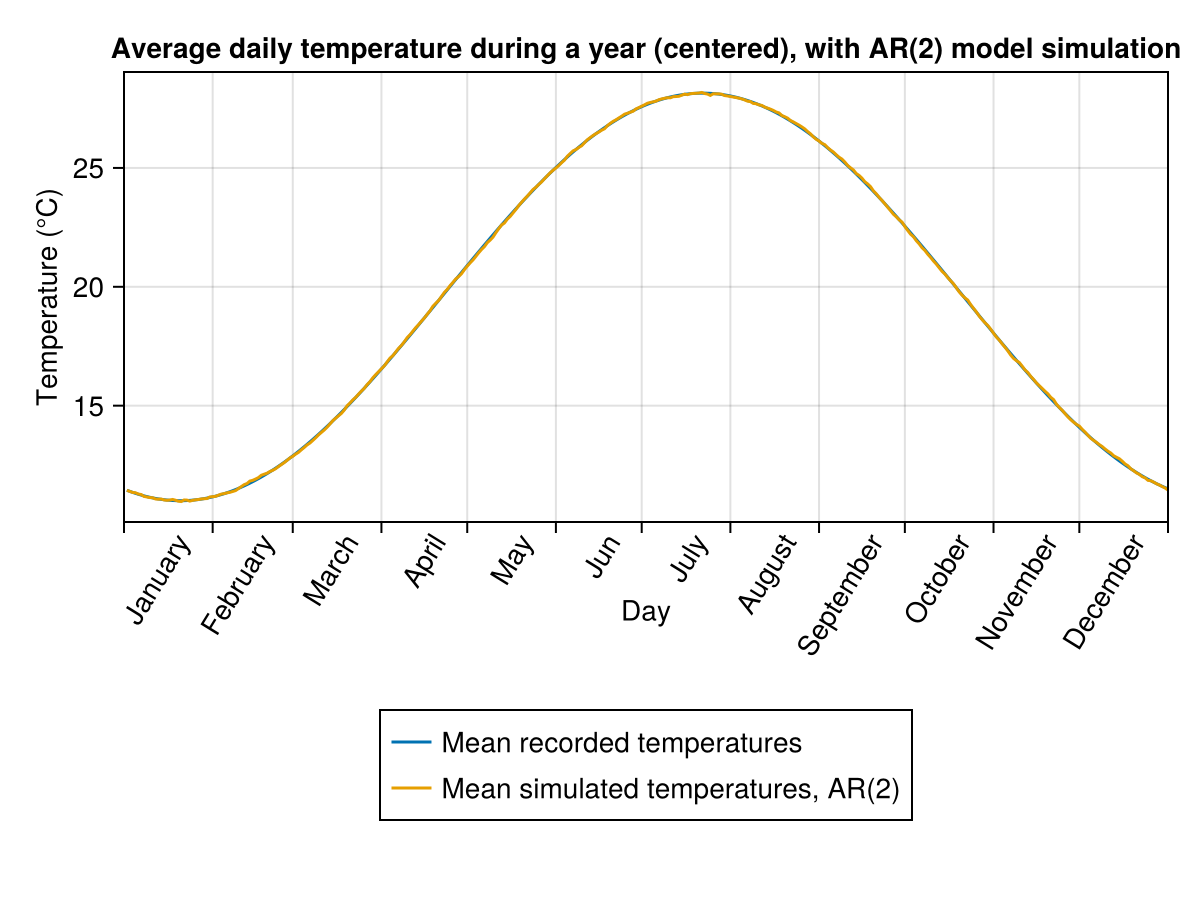

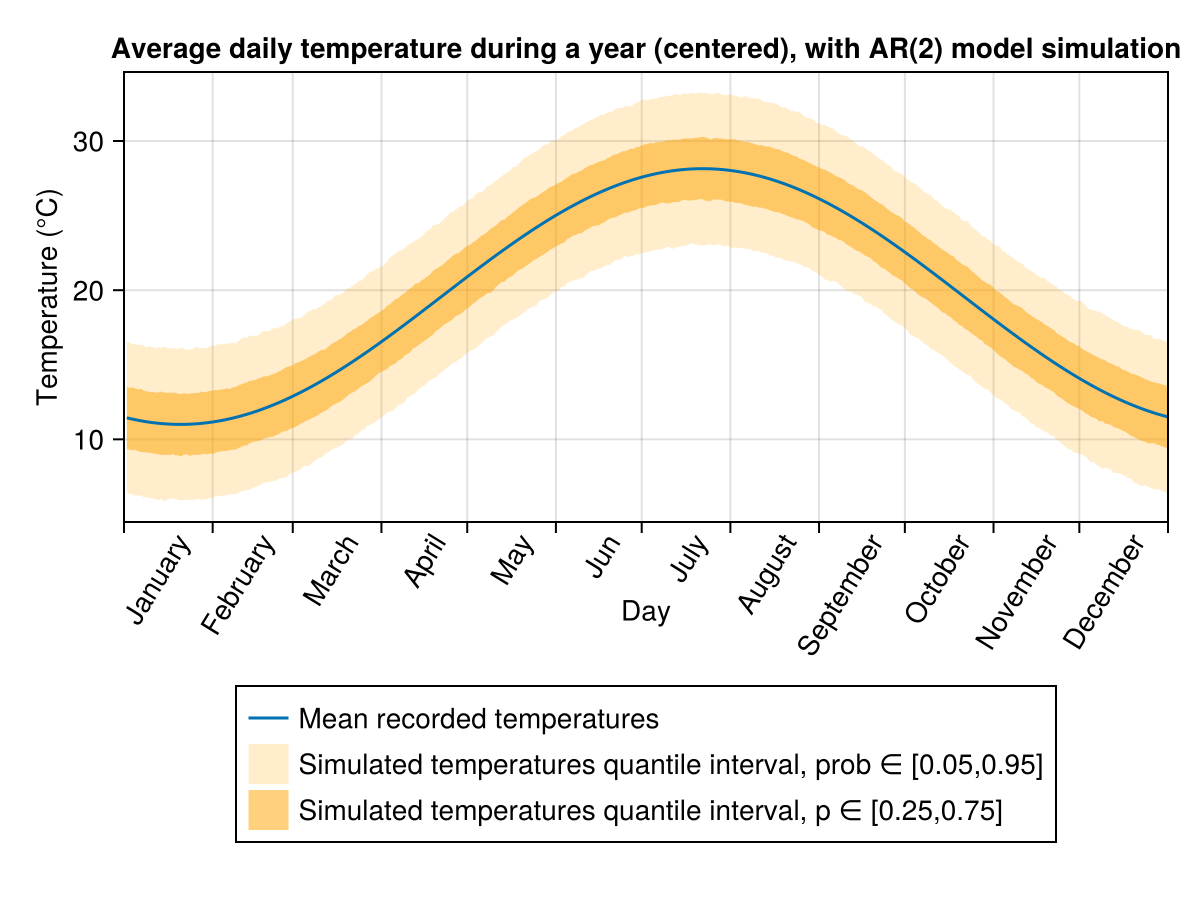

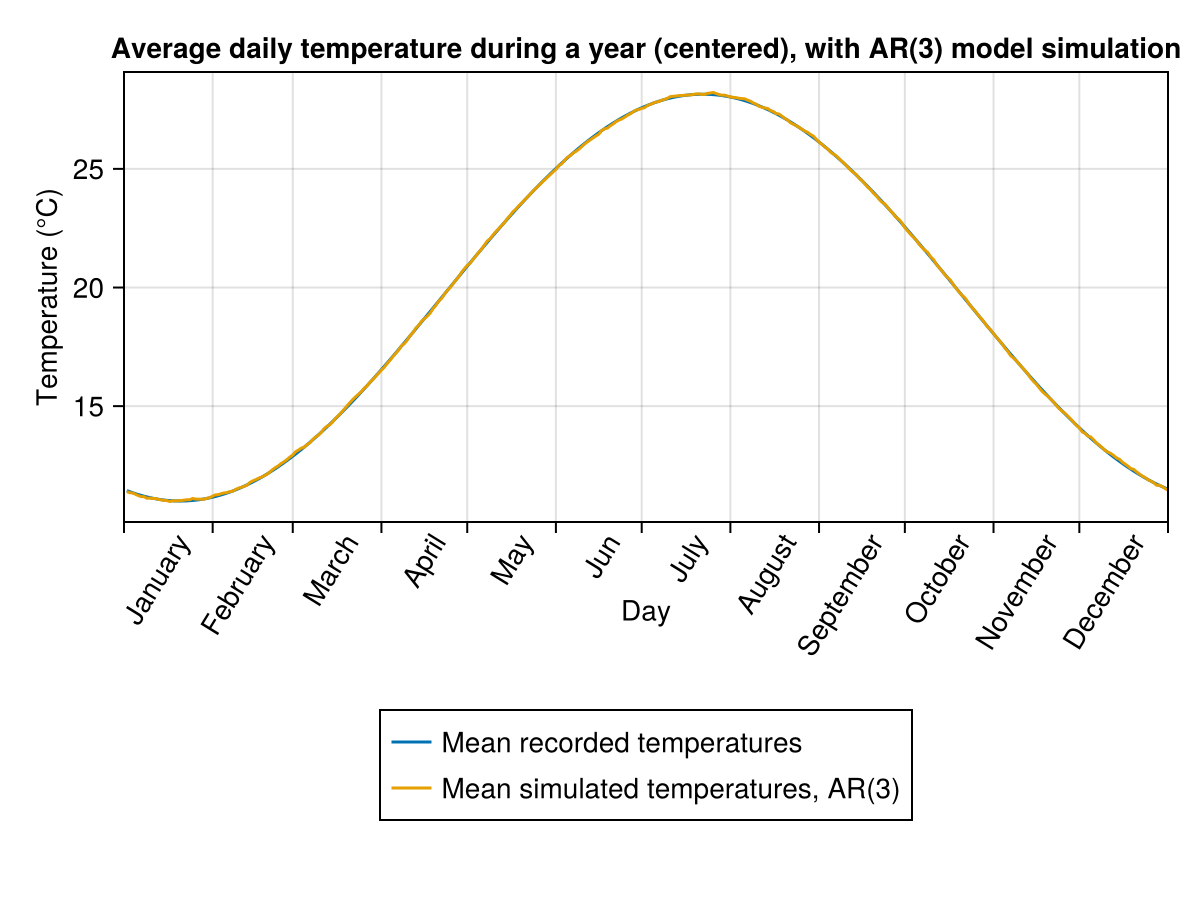

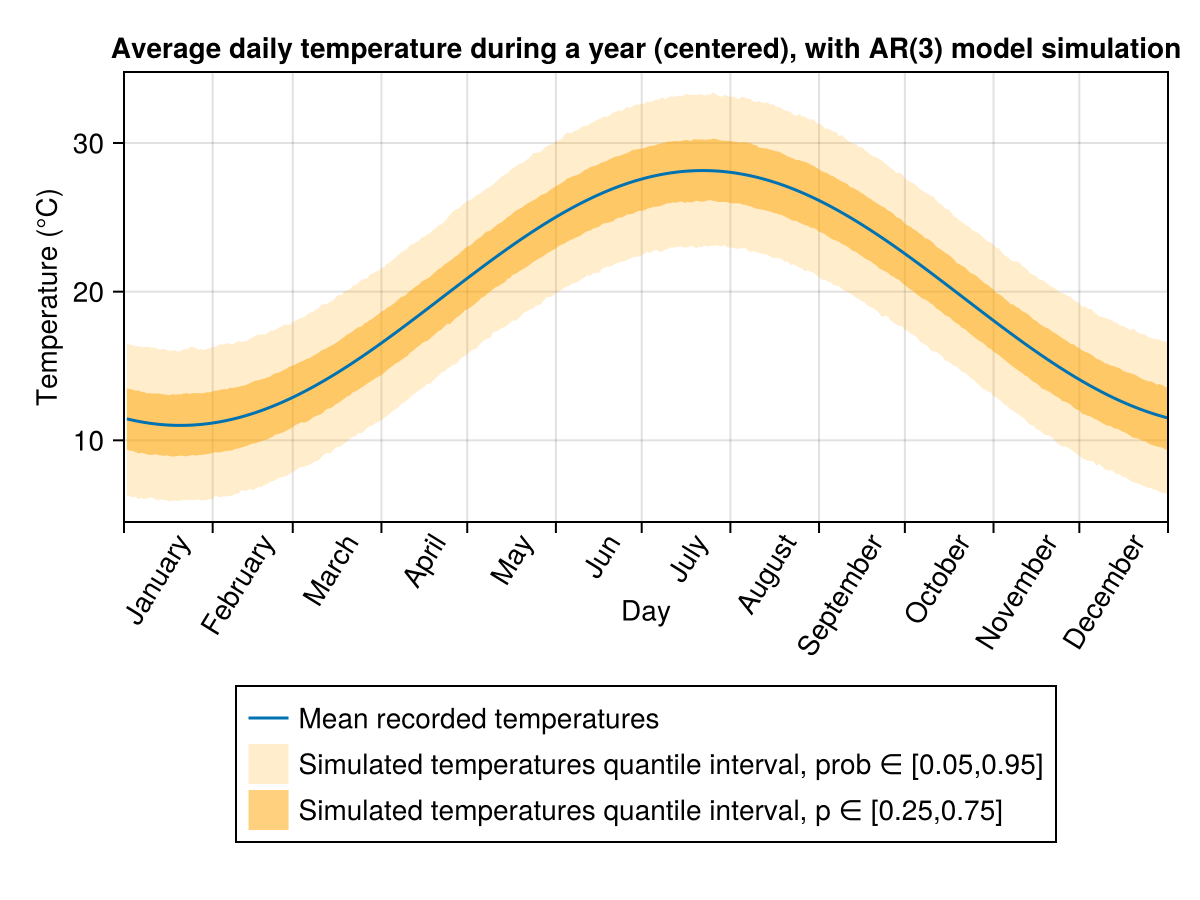

In [10]:
for p in 1:3
    Φ, σ=LL_AR_Estimation(x,p)
    sample_=invert(sample_simulation(x[1:p],Φ,σ,periodicity,10000))
    display(PlotYearCurves([periodicity[1:365],mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures, AR($(p))"],"Average daily temperature during a year (centered), with AR($(p)) model simulation"))
    display(PlotYearCurves(periodicity[1:365],
    ["Mean recorded temperatures","Simulated temperatures quantile interval, prob ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
    "Average daily temperature during a year (centered), with AR($(p)) model simulation",
    [(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
    [("orange",0.2),("orange",0.5)]
    ))
end

# 2.Periodicity with regularization smoothing

In this model we use regularization smoothing on the average daily temperature to make our periodicity function. 
(see : https://docs.sciml.ai/DataInterpolations/stable/methods/)

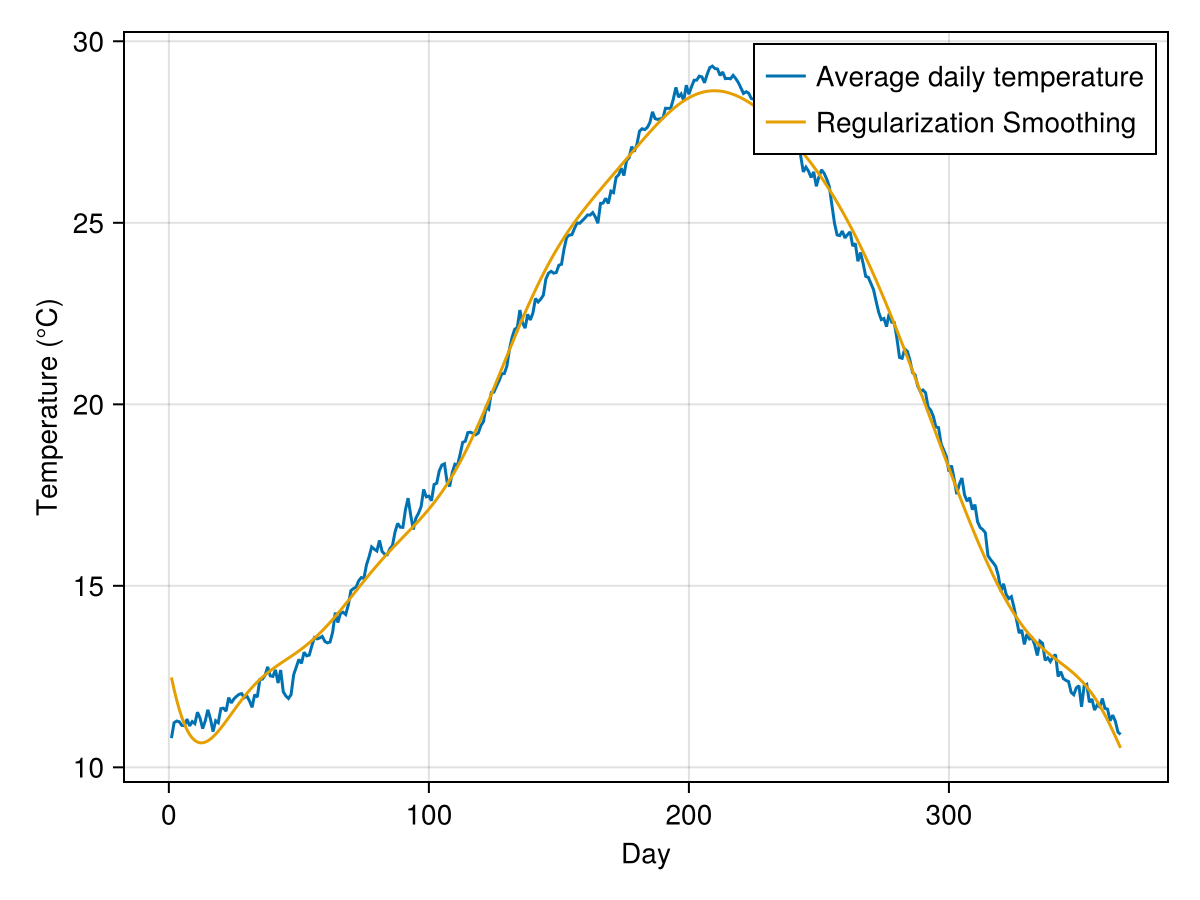

In [11]:
include("utils/Periodicity.jl")
t_vec=n2t.(1:N,series.DATE[1])
Days_list=[[] for _ in 1:366]
for (i,temp) in enumerate(series[!,2])
    push!(Days_list[n2t(i,series.DATE[1])],temp)
end

f=RegularizationSmooth(mean.(Days_list), 1:366, 9)
fig=Figure()
ax ,plt1= lines(fig[1:2,1:2],mean.(Days_list))
plt2=lines!(ax,f(1:366))
ax.xlabel="Day"
ax.ylabel="Temperature (°C)"
axislegend(ax,[plt1,plt2],["Average daily temperature","Regularization Smoothing"])
current_figure()

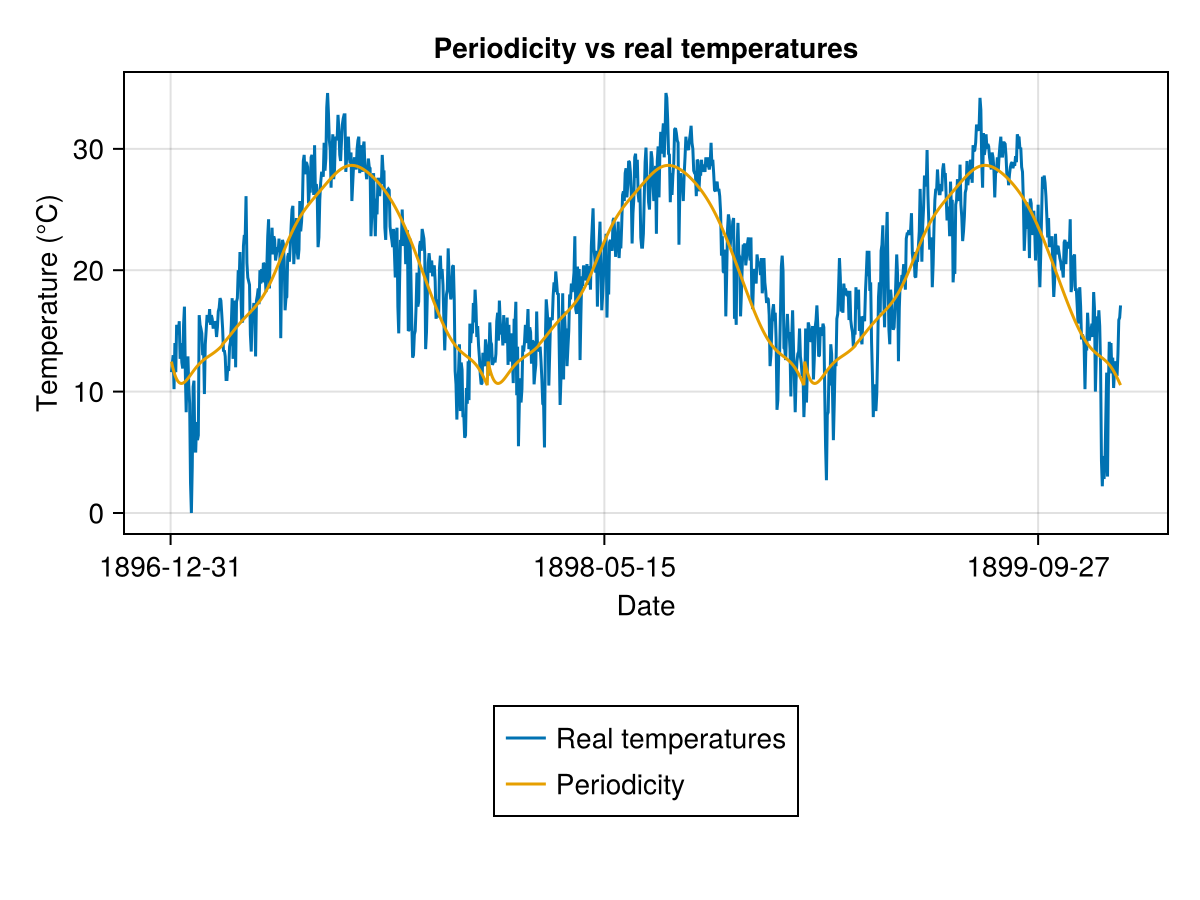

In [12]:
Smoothed_function(i)=f(n2t(i,series.DATE[1]))
periodicity=Smoothed_function.(1:N)

fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[1]):year(series.DATE[1]) + 2)
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
current_figure()

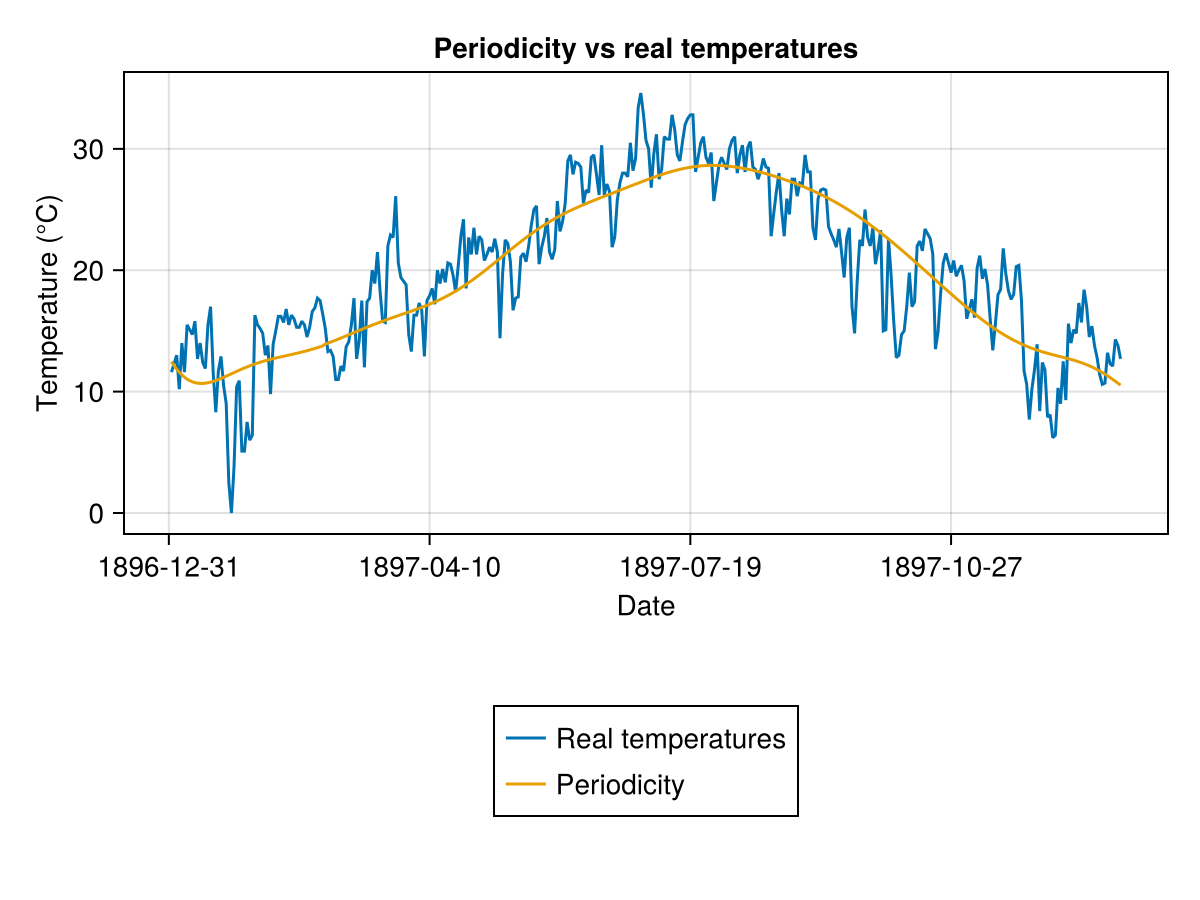

1897-01-01
1897-12-31


CairoMakie.Screen{IMAGE}


In [13]:
fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[1]))
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
println(series.DATE[Myyear][1])
println(series.DATE[Myyear][end])
display(fig)

## Estimation and simulation

In [14]:
include("utils/Estimation.jl")
include("utils/Simulation.jl")
include("utils/Plotting.jl")

PlotParameters

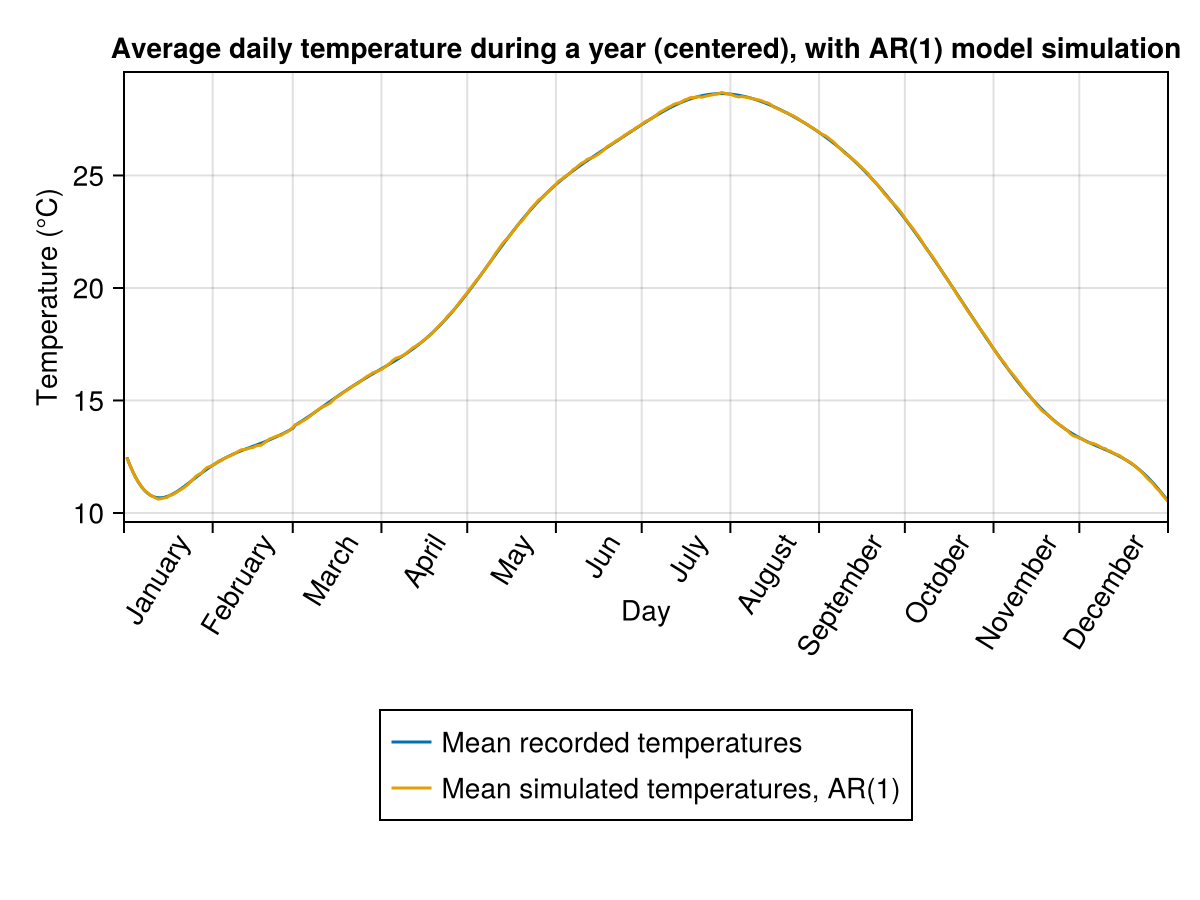

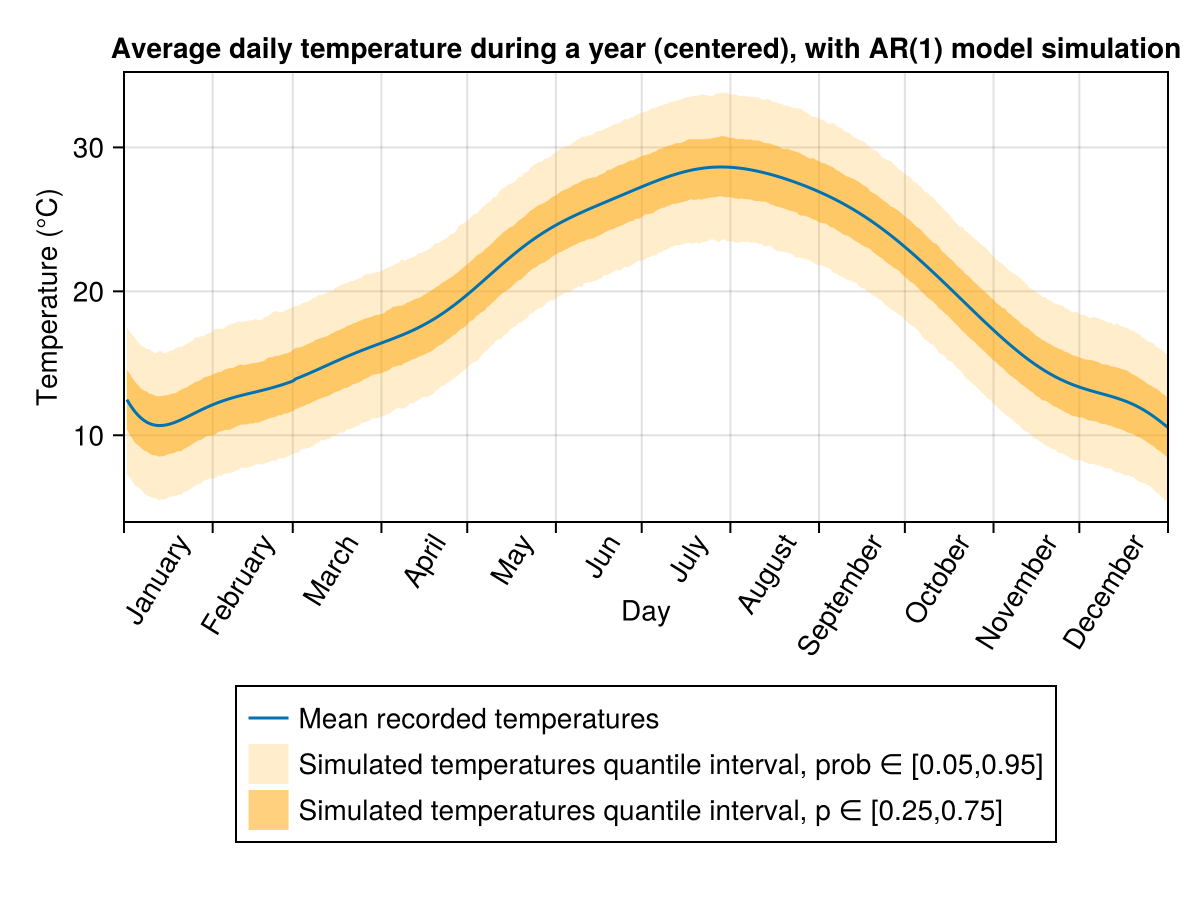

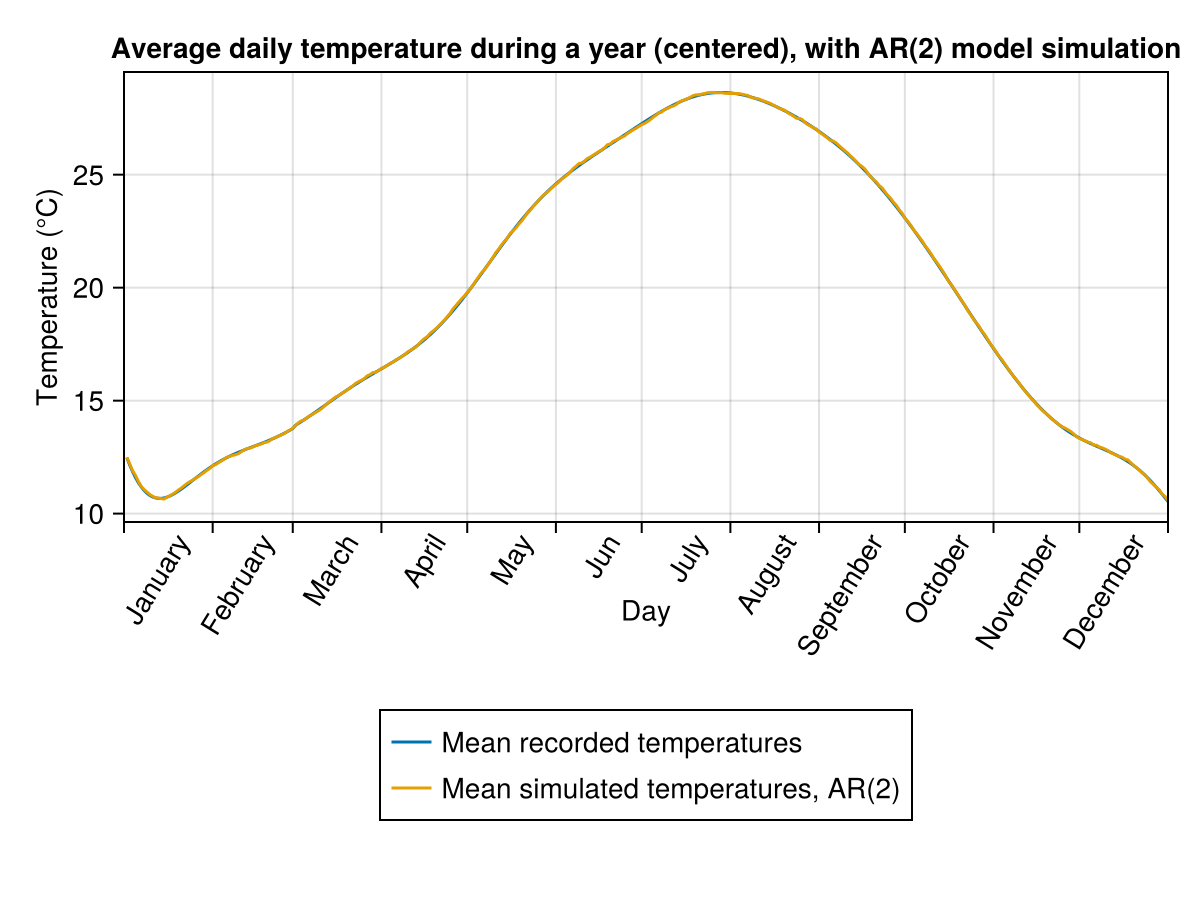

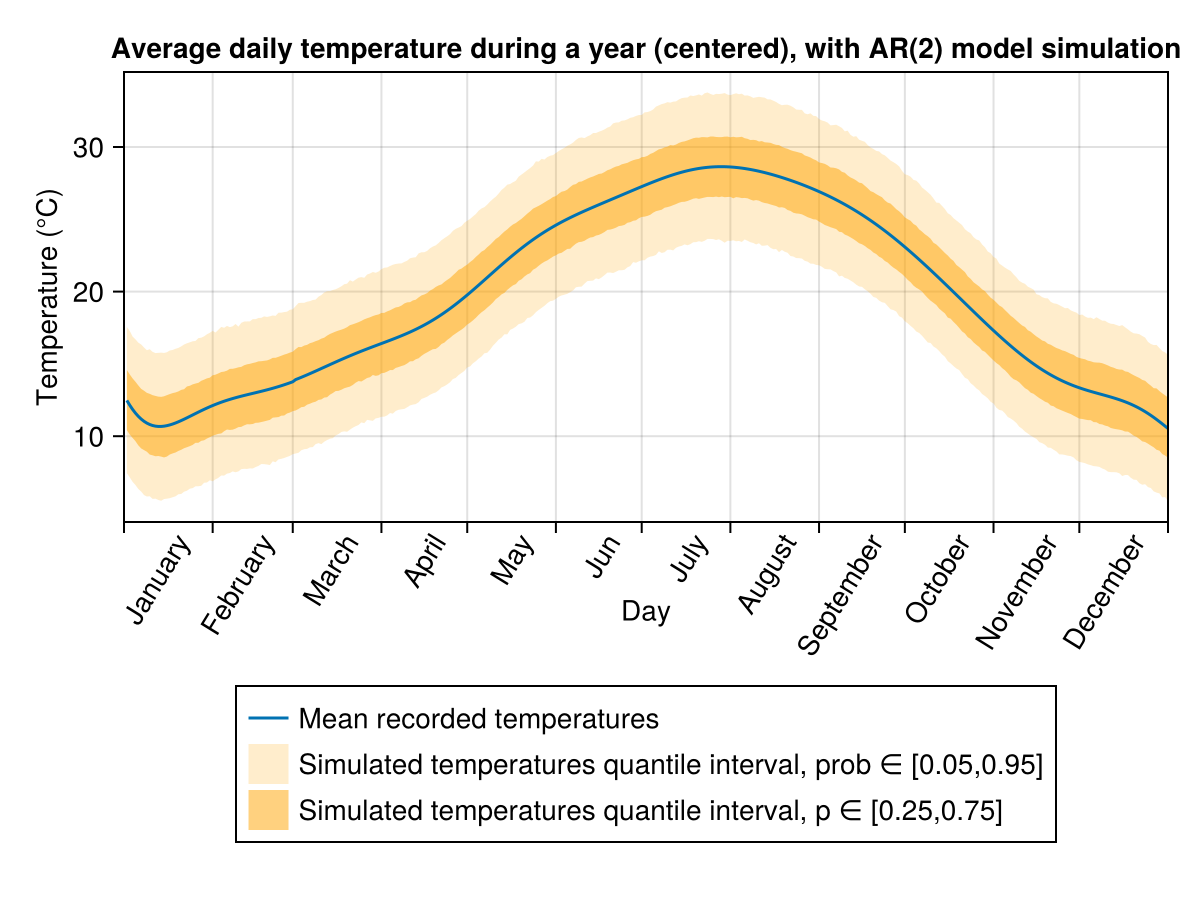

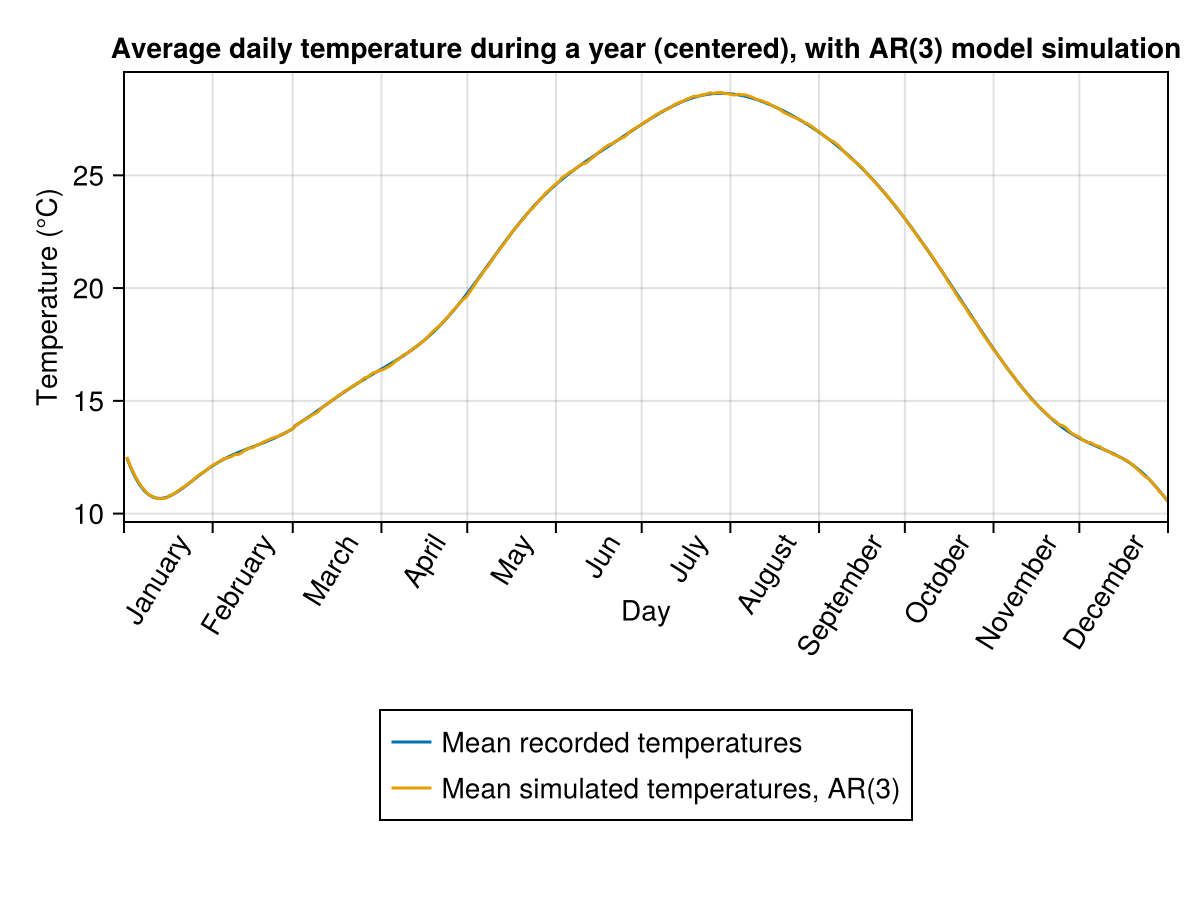

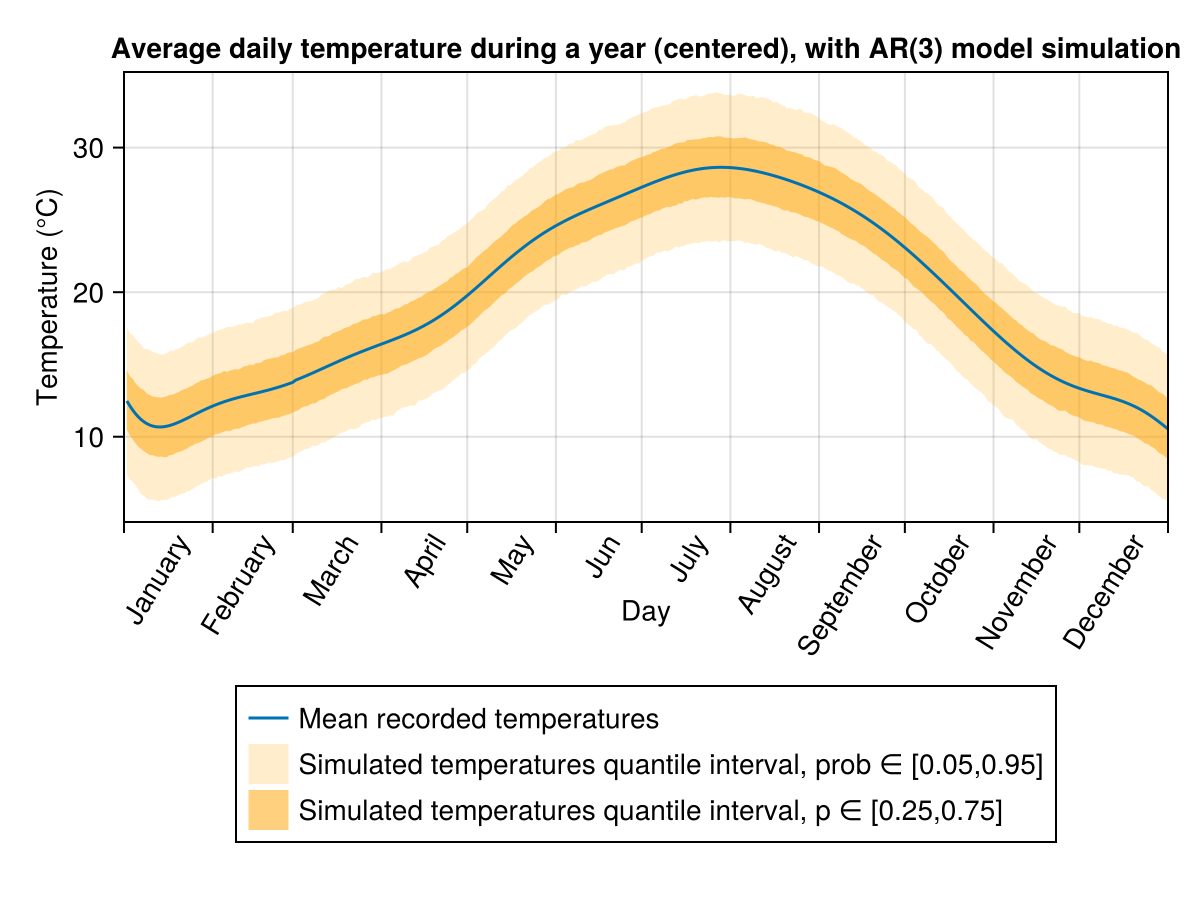

In [15]:
for p in 1:3
    Φ, σ=LL_AR_Estimation(x,p)
    sample_=invert(sample_simulation(x[1:p],Φ,σ,periodicity,10000))
    display(PlotYearCurves([periodicity[1:365],mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures, AR($(p))"],"Average daily temperature during a year (centered), with AR($(p)) model simulation"))
    display(PlotYearCurves(periodicity[1:365],
    ["Mean recorded temperatures","Simulated temperatures quantile interval, prob ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
    "Average daily temperature during a year (centered), with AR($(p)) model simulation",
    [(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
    [("orange",0.2),("orange",0.5)]
    ))
end

For both of this methods, the imputation of data has corrected the shift between the periodicity and the real series.